In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


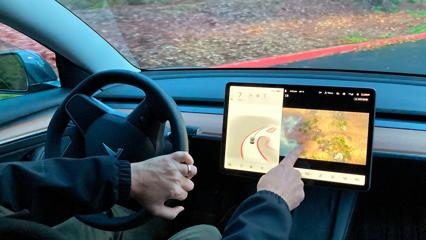

[Is Tesla's 'Full Self-Driving' a fraud on consumers?](https://www.washingtonpost.com/technology/2024/07/11/elon-musk-tesla-full-self-driving/) - Washington Post

___

[Google also implements features like summarizing your docs (and training on them?) with no way to turn it off.](https://x.com/kevinbankston/status/1811075836558114968) - X (formerly Twitter)

___

[All that robot and surveillance tech from companies like Anduril for the border and the military will be coming to your local police department soon.](https://www.texasobserver.org/border-surveillance-artificial-intelligence-tech/)

___

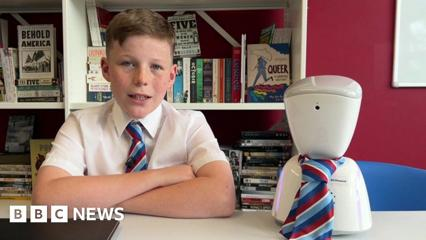

[Sick pupil attends school via robot.](https://www.bbc.com/news/articles/c7280m3gy14o)

___

Just what we were hoping for, a world populated entirely by mini-Musks

[Musk's plan to colonize Mars includes seeding it with his own sperm.](https://www.nytimes.com/2024/07/11/technology/elon-musk-spacex-mars.html)

___

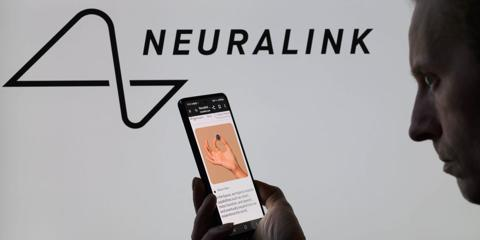

[Musk: if you are paranoid that we have already put a chip in your brain, in the future we can implant a chip to make sure you don't think that.](https://www.businessinsider.com/elon-musk-neuralink-update-what-to-expect-2024-7) - Business Insider

___

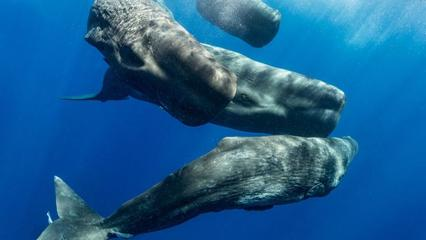

[Sperm whales' phonetic alphabet revealed by AI, paving the way toward interspecies communication.](https://www.bbc.com/future/article/20240709-the-sperm-whale-phonetic-alphabet-revealed-by-ai)

___

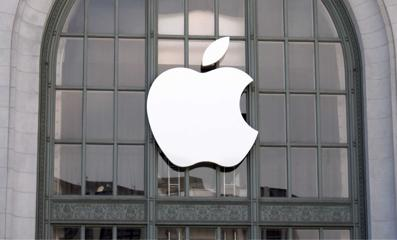

[Based on initial orders Apple is targeting a 10% increase in iPhone shipments with new AI features.](https://me.mashable.com/tech/43922/apple-targets-10-rise-in-iphone-shipments-with-ios-18-ai-features-in-2024) - Mashable ME

___

[FTC source says giving up OpenAI board seat won't do much to alleviate Microsoft antitrust concerns.](https://www.reuters.com/technology/microsoft-ditches-openai-board-observer-seat-amid-regulatory-scrutiny-2024-07-10/)

___

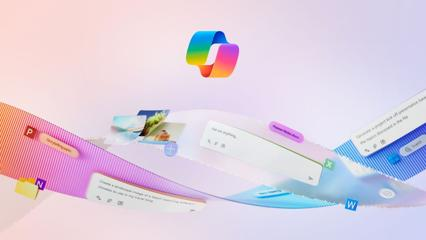

[Copilot AI going into Windows 10 as part of mandatory update.](https://www.techradar.com/computing/windows/hanging-onto-windows-10-to-avoid-copilot-ai-ive-got-bad-news-for-you) - TechRadar

___

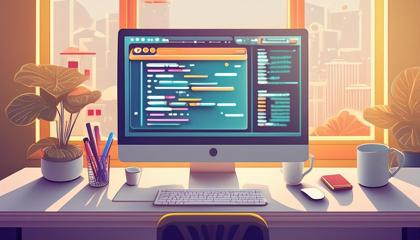

[AWS App Studio turns text into enterprise apps in minutes.](https://venturebeat.com/ai/aws-app-studio-turns-text-into-enterprise-apps-in-minutes/) - VentureBeat

___

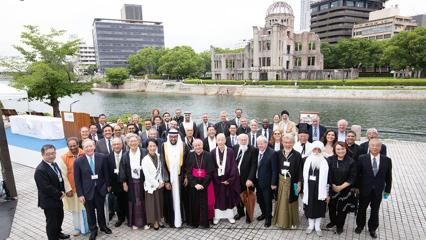

[Pope Francis: Just say no to lethal autonomous weapons.](https://www.vaticannews.va/en/pope/news/2024-07/pope-reconsider-the-development-of-lethal-autonomous-weapons.html)

___

[FT on Nvidia skeptics. 

GPU shortage has expanded profit margins to an insane level. At sane margins the opportunity is smaller than expected even if AI deployment grows faster than expected. If margins stay high, biggest hyperscalers adapt their stacks to use other chips and custom silicon.](https://www.ft.com/content/243a5e9a-016b-4d59-b2ba-2de4f65161b9)

___

[AMD buys Finnish Silo AI to have its own foundation LLM.](https://www.reuters.com/markets/deals/amd-acquire-finnish-startup-silo-ai-665-mln-step-up-ai-race-2024-07-10/)

___

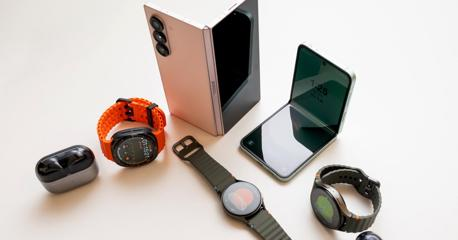

[Samsung announces a bunch of stuff, including a ring with an AI health tracker.](https://www.wired.com/story/samsung-galaxy-unpacked-july-2024-flip6-fold6-galaxy-ring/) - WIRED

___

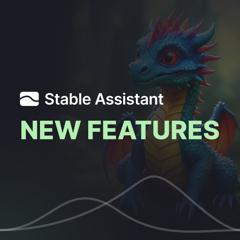

[Stability added a music generation model to their chatbot assistant.](https://stability.ai/news/stability-ai-releases-stable-assistant-features) - Stability AI

___

making a LLM that hallucinates 100% of the time and calling it 'Trust me bro'

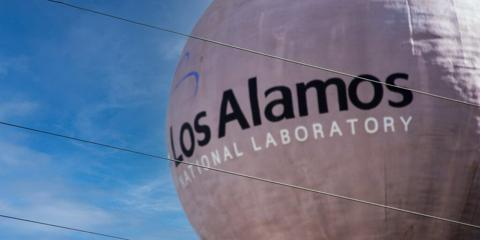

[OpenAI to build bioscience at Los Alamos, where nothing regrettable has ever been created.](https://decrypt.co/239290/openai-los-alamos-ai-bioscience) - Decrypt

___

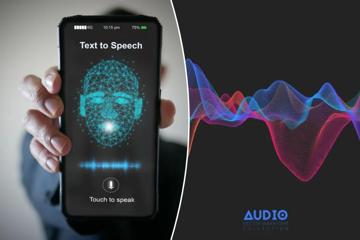

[Say something is too dangerous to release, everyone starts talking about it.](https://nypost.com/2024/07/10/lifestyle/ai-speech-clone-is-so-real-that-makers-say-its-potential-risks-could-prove-too-dangerous/) - New York Post

___

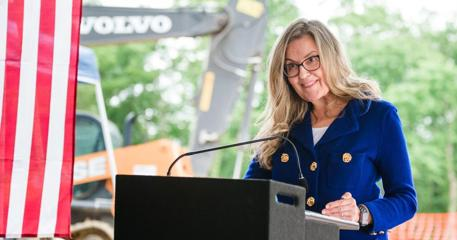

[ElevenLabs helps Congresswoman recreate her voice after losing it to degenerative disease. 

(Maybe AI can give Joe Biden some help?)](https://www.fredericknewspost.com/news/health/treatment_and_diseases/virginia-congresswoman-debuts-ai-voice-model-after-losing-natural-voice-to-illness/article_d5e80fac-3ef6-11ef-bbe4-1329be5fdf3b.html) - The Frederick News-Post 

___

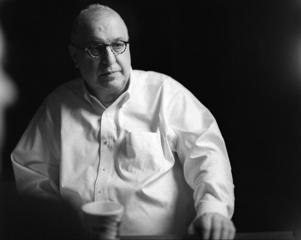

[Erroll Morris on the use of gen-AI in documentaries.](https://www.niemanlab.org/2024/07/errol-morris-on-whether-you-should-be-afraid-of-generative-ai-in-documentaries/) - Nieman Lab

___

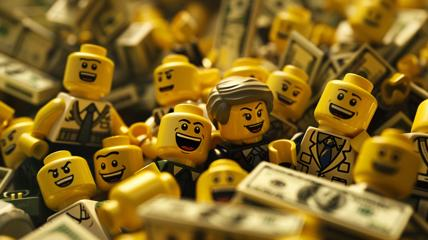

[AI hedge fund pays interns \\$20k per month.](https://www.efinancialcareers.com/news/an-ai-trading-firm-paying-5x-as-much-as-jane-street-in-london-has-been-hiring) - eFinancialCareers

___

[Intuit lays off 10% of its workforce, looks to hire people to work on AI.](https://www.theregister.com/2024/07/10/intuit_decimates_staff_announces_plans/)

___

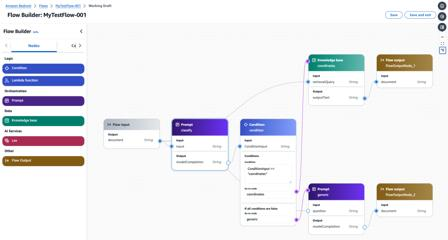

[Amazon adds prompt engineering tools in Bedrock.](https://aws.amazon.com/blogs/machine-learning/streamline-generative-ai-development-in-amazon-bedrock-with-prompt-management-and-prompt-flows-preview/) - Amazon Web Services

___

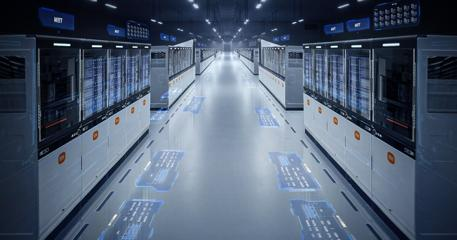

[Xiaomi says its fully automated, lights-out factory will produce 10m phones per years.](https://newatlas.com/robotics/xiaomi-dark-robotic-factory/) - New Atlas

___

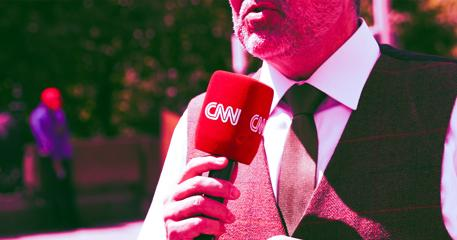

[CNN lays off 100, pursues 'strategic push into AI'](https://futurism.com/the-byte/cnn-firing-employees-push-into-ai) - Futurism

___

[Can AI be meaningfully regulated? (A: yes, WTF is wrong with you?)](https://www.securityweek.com/can-ai-be-meaningfully-regulated-or-is-regulation-a-deceitful-fudge/)

___

[Doctors use AI to help deal with insurance companies. Of course, insurance companies use AI to deny claims. Or just a giant Nope button.](https://www.nytimes.com/2024/07/10/health/doctors-insurers-artificial-intelligence.html)

___

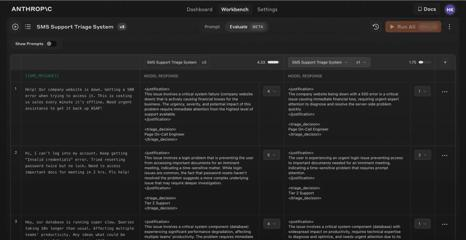

[Anthropic adds Web console features to create and evaluate prompts.](https://www.maginative.com/article/anthropic-introduces-new-console-features-to-enhance-ai-prompt-engineering/) - Maginative

___

jailbreaks are a feature not a bug

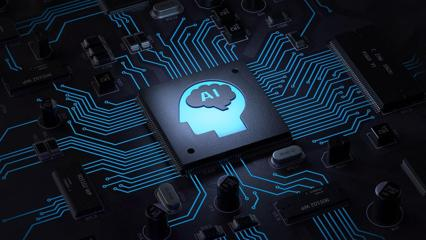

[How BCG is transforming consulting with AI.](https://www.forbes.com/sites/bernardmarr/2024/07/10/how-bcg-is-revolutionizing-consulting-with-ai-a-case-study/) - Forbes

___

[Elon Musk snarks at Sam Altman over his pricey car.

2 power-hungry lunatics, 1 seems smarmy and self-serving, 1 always seems to be in a one-sided pissing match with everybody.](https://x.com/elonmusk/status/1810901569006883096) - X (formerly Twitter)

___

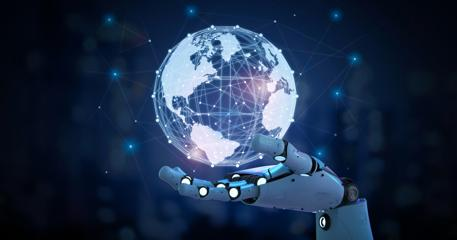

[World AI conference declaration echoes Asimov's laws of robotics.](https://newatlas.com/technology/china-artificial-intelliegencei-guideline-humanity-first/) - New Atlas

___

[The Babelfish is here.](https://www.theregister.com/2024/07/10/timekettle_x1_ai_interpreter_hub/)

___

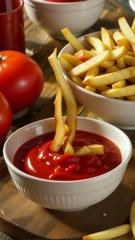

[Dancing french fries go viral](https://www.youtube.com/watch?v=D8RpE_JDpOA) - YouTube

___

An interview with Meta's CTO about AR and the metaverse.

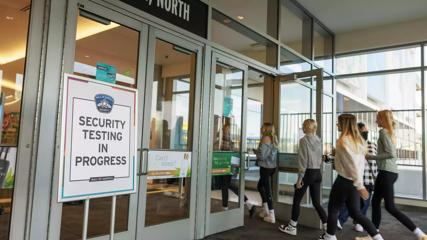

[Mall of America adds facial recognition. 

(Same company's mall near NY is very troubled, news that American Dream is going bankrupt seems apt)](https://www.mprnews.org/story/2024/07/09/new-ai-security-measure-at-mall-of-america-raises-concerns-for-some) - MPR News

___

[Lee Saedol talks about losing to AI, and how a lot of people are going to be surprised to find out AI is better than them at stuff they care about and poured themselves into.](https://www.nytimes.com/2024/07/10/world/asia/lee-saedol-go-ai.html)

___

[Bill Gates writes about seeing Khanmigo in use on a field trip to Newark schools.](https://www.gatesnotes.com/My-trip-to-the-frontier-of-AI-education)

___

[The spending on Nvidia is unsustainable, so it will not be sustained LOL.](https://www.bloomberg.com/opinion/articles/2024-07-10/will-ai-ever-pay-off-venture-capitalists-footing-the-bill-are-worrying-already)

___

Sometimes there are Googles and you want to get in early and hold forever, and not worry too much if the price gets a couple of years ahead of reality if you want to hold for decades. But sometimes there are boom-and-bust situations like AOL, or TheGlobe, or Cisco comparison seems very on point.

[I wrote something similar a while back in a CFA Institute blog post.](https://druce.ai/2013/08/risk-arbitrage-investing-and-poker/) - Druce.ai

___

[Passive investors and the AI bubble. I don't really agree with the premises of the thought experiment. In a real market there is no freeze, more passive investors make the market  marginally thinner and more vulnerable to the herd stampeding. It is complicated though.](https://www.ft.com/content/201d1234-58cc-40a1-be46-b1820f63ccee)

___

[Microsoft and Apple give up OpenAI board observer seats amid antitrust scrutiny.](https://www.ft.com/content/ecfa69df-5d1c-4177-9b14-a3a73072db12)

___

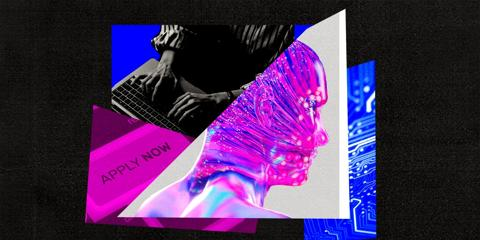

[AI 'magical teleprompter' helpers listen in to job interviews and give candidates hints in real-time.](https://www.businessinsider.com/ai-job-interview-tools-final-round-otter-2024-7) - Business Insider

___

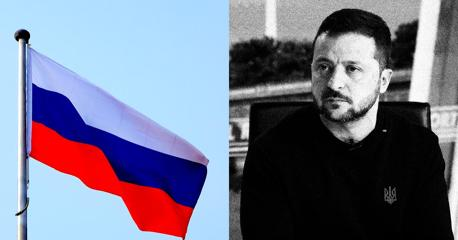

[How Disinformation From a Russian AI Spam Farm Ended up on Top of Google Search Results](https://www.wired.com/story/ai-generated-russian-disinformation-zelensky-bugatti/) - WIRED

___

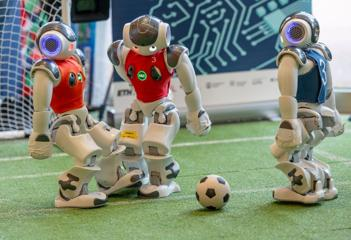

[AI startup funding more than doubles from a year ago in Q2,  up 16% sequentially, Crunchbase data shows](https://finance.yahoo.com/news/ai-startup-funding-more-doubles-122445641.html) - Yahoo Finance

___

[Why conscious AI would experience beauty. 

Does Midjourney experience beauty?](https://3quarksdaily.com/3quarksdaily/2024/07/why-conscious-ai-would-experience-beauty.html)

___

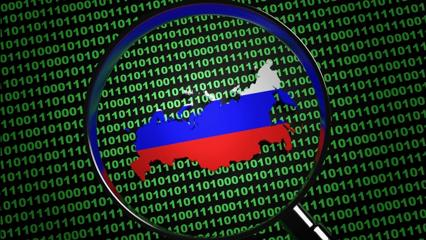

[US crashes Russian bot farm that used AI to spread propaganda.](https://www.pcmag.com/news/us-disrupts-russian-bots-spreading-propaganda-on-twitter) - PCMAG

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 7, 11, 15, 14, 38, 80000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-07-10 05:17:41.415746


In [13]:
sqlite

NameError: name 'sqlite' is not defined